In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
data = pd.read_csv("without_HardwareTroj.csv").drop("HT", axis=1)

In [6]:
data

,Impedance,Resistance,Reactance
0,56.85,-798.00,3.950000e-11
1,67.83,-850.18,3.600000e-11
2,59.84,-835.34,3.560000e-11
3,60.60,-805.52,3.590000e-11
4,59.28,-778.88,3.620000e-11
...,...,...,...
9996,196.93,174.59,1.860000e-08
9997,197.90,174.75,1.860000e-08
9998,201.87,174.87,1.860000e-08
9999,200.02,173.07,1.840000e-08


In [7]:
# Select the columns you want to predict
columns_to_predict = ['Impedance', 'Resistance', 'Reactance']

# # Normalize the data using Min-Max scaling
# scaler = MinMaxScaler()
# data[columns_to_predict] = scaler.fit_transform(data[columns_to_predict])

In [8]:
data

,Impedance,Resistance,Reactance
0,56.85,-798.00,3.950000e-11
1,67.83,-850.18,3.600000e-11
2,59.84,-835.34,3.560000e-11
3,60.60,-805.52,3.590000e-11
4,59.28,-778.88,3.620000e-11
...,...,...,...
9996,196.93,174.59,1.860000e-08
9997,197.90,174.75,1.860000e-08
9998,201.87,174.87,1.860000e-08
9999,200.02,173.07,1.840000e-08


In [9]:
# data[columns_to_predict] = scaler.inverse_transform(data[columns_to_predict])
# data

In [10]:
sequence_length = 5 

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length][columns_to_predict].values)
        y.append(data.iloc[i+sequence_length][columns_to_predict].values)
    return np.array(X), np.array(y)

X, y = create_sequences(data, sequence_length)

In [11]:
X.shape

(9996, 5, 3)

In [12]:
y.shape

(9996, 3)

In [13]:
# Define the split ratio (e.g., 80% train, 20% test)
split_ratio = 0.8

# Calculate the split index
split_index = int(len(X) * split_ratio)

# Split the data into train and test sets
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [14]:
print(X_train.shape, X_test.shape)

(7996, 5, 3) (2000, 5, 3)


In [15]:
print(y_train.shape, y_test.shape)

(7996, 3) (2000, 3)


In [38]:
# Create the model
model = Sequential()

model.add(LSTM(48, input_shape=(sequence_length, len(columns_to_predict)), activation='relu', return_sequences=True))

model.add(LSTM(16, activation='relu'))  
model.add(Dropout(0.001))

model.add(Dense(len(columns_to_predict)))

# Compile the model with custom learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Print the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 48)             9984      
                                                                 
 lstm_5 (LSTM)               (None, 16)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 14195 (55.45 KB)
Trainable params: 14195 (55.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, verbose=1, callbacks=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3))


Epoch 1/60
200/200 [==============================] - 7s 12ms/step - loss: 5543.2227 - val_loss: 7662.3350
Epoch 2/60
200/200 [==============================] - 2s 8ms/step - loss: 2851.3606 - val_loss: 5191.4004
Epoch 3/60
200/200 [==============================] - 2s 10ms/step - loss: 1746.6229 - val_loss: 2986.9309
Epoch 4/60
200/200 [==============================] - 2s 8ms/step - loss: 849.6479 - val_loss: 1039.7078
Epoch 5/60
200/200 [==============================] - 2s 9ms/step - loss: 481.3525 - val_loss: 931.4771
Epoch 6/60
200/200 [==============================] - 2s 9ms/step - loss: 423.8629 - val_loss: 968.7609
Epoch 7/60
200/200 [==============================] - 2s 9ms/step - loss: 419.9160 - val_loss: 849.3763
Epoch 8/60
200/200 [==============================] - 2s 9ms/step - loss: 354.6136 - val_loss: 666.2211
Epoch 9/60
200/200 [==============================] - 2s 9ms/step - loss: 282.3970 - val_loss: 495.1439
Epoch 10/60
200/200 [==============================] - 

Text(0.5, 1.0, 'Loss Curves')

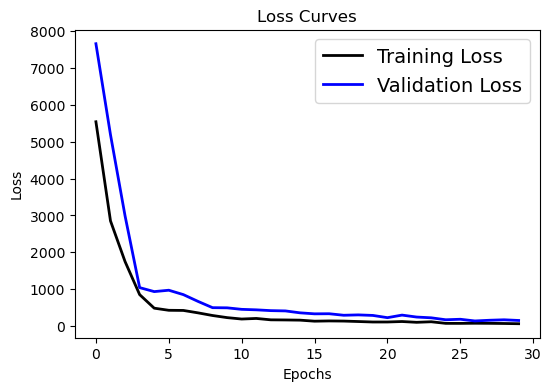

In [40]:
# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [41]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

63/63 [==============================] - 1s 5ms/step - loss: 6.8479
Test Loss: 6.8479084968566895


In [42]:
predictions = model.predict(X_train)

250/250 [==============================] - 2s 4ms/step


In [43]:
predictions.shape

(7996, 3)

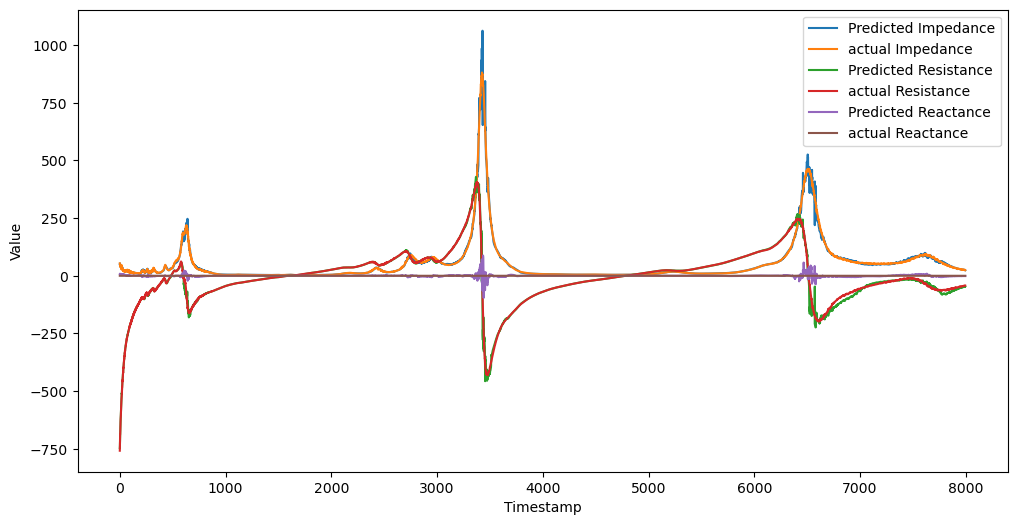

In [44]:
#plotting the train vs predicted 


plt.figure(figsize=(12, 6))
for i, column in enumerate(columns_to_predict):
    plt.plot(predictions[:, i], label=f'Predicted {column}')
    plt.plot(y_train[:, i], label=f'actual {column}')

plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [45]:
predictions = model.predict(X_test)

63/63 [==============================] - 0s 4ms/step


In [46]:
predictions.shape

(2000, 3)

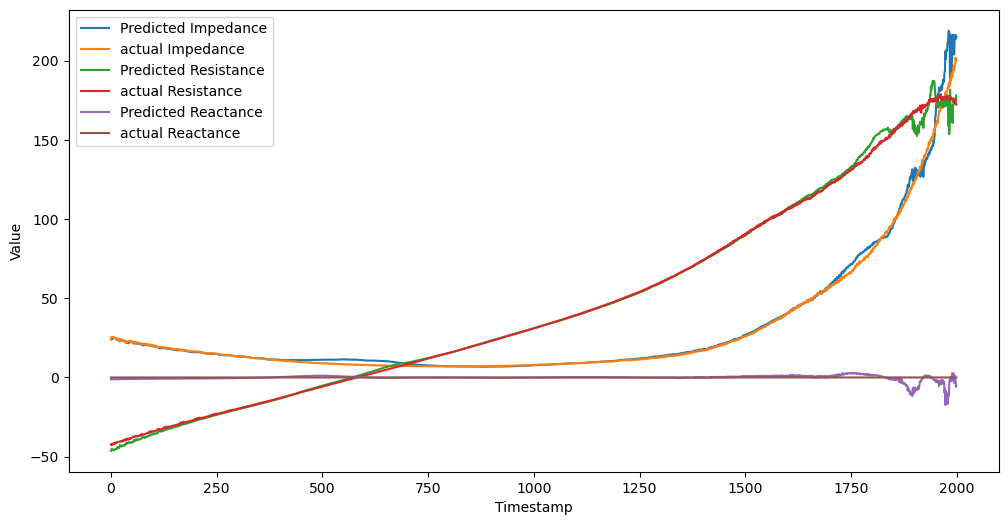

In [47]:
# plotting the test vs predicted

plt.figure(figsize=(12, 6))
for i, column in enumerate(columns_to_predict):
    plt.plot(predictions[:, i], label=f'Predicted {column}')
    plt.plot(y_test[:, i], label=f'actual {column}')

plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

comparing the predicted values vs actual values for our test dataset.

In [48]:

pd.DataFrame(model.predict(X_test))

63/63 [==============================] - 0s 4ms/step


,0,1,2
0,24.013687,-46.244133,-1.201411
1,23.831488,-45.853970,-1.129464
2,23.955702,-45.026012,-0.956884
3,24.236500,-45.377377,-0.960767
4,24.573957,-45.517292,-1.055018
...,...,...,...
1995,215.922806,173.827667,0.731984
1996,213.492508,173.318817,1.037172
1997,216.267776,175.678101,-1.238803
1998,213.860733,178.119446,-5.959108


In [49]:
pd.DataFrame(y_test)

,0,1,2
0,24.16,-42.25,3.150000e-12
1,25.49,-42.79,3.110000e-12
2,25.37,-42.72,3.110000e-12
3,25.63,-42.00,3.160000e-12
4,25.63,-41.93,3.170000e-12
...,...,...,...
1995,196.93,174.59,1.860000e-08
1996,197.90,174.75,1.860000e-08
1997,201.87,174.87,1.860000e-08
1998,200.02,173.07,1.840000e-08


In [50]:
pd.DataFrame(model.predict(X_train))

250/250 [==============================] - 1s 4ms/step


,0,1,2
0,50.335316,-746.952637,7.606476
1,53.493732,-737.746643,7.503293
2,51.552380,-716.818970,7.228951
3,52.080257,-696.154419,6.491963
4,48.099598,-676.855225,7.125226
...,...,...,...
7991,25.152138,-47.956814,-1.334882
7992,24.681580,-46.881931,-1.249046
7993,24.864624,-46.113667,-1.059619
7994,24.737089,-46.443951,-1.116017


In [51]:
pd.DataFrame(y_train)

,0,1,2
0,53.85,-758.55,3.620000e-11
1,50.79,-742.23,3.610000e-11
2,49.20,-707.27,3.690000e-11
3,47.00,-686.68,3.710000e-11
4,44.77,-686.41,3.630000e-11
...,...,...,...
7991,25.11,-43.11,3.090000e-12
7992,25.63,-43.21,3.080000e-12
7993,25.16,-42.78,3.110000e-12
7994,24.41,-42.51,3.130000e-12


A demo on how to make predictions on the data the model has never seen before. we are giving the last 6 rows of data to our model. and it's gonna predict us the next 
* the model will need the previous 6 reading to be able to predict the next values.



In [61]:
data.iloc[9000:9006]

,Impedance,Resistance,Reactance
9000,7.96,30.89,3.650000e-09
9001,7.89,31.07,3.670000e-09
9002,7.94,31.16,3.680000e-09
9003,7.92,31.25,3.690000e-09
9004,7.99,31.22,3.690000e-09
9005,7.93,31.27,3.700000e-09


In [62]:

# assign your new dataset to new_data variable..
new_data = data.iloc[9000:9006]


# Create sequences for prediction
X_new = []


for i in range(len(new_data) - sequence_length):
    X_new.append(new_data[columns_to_predict].iloc[i:i+sequence_length].values)

X_new = np.array(X_new)

# Make predictions
predictions = model.predict(X_new)


predictions = pd.DataFrame(predictions)
predictions

1/1 [==============================] - 0s 48ms/step


,0,1,2
0,7.757646,31.319336,-0.038525


In [63]:
new_data

,Impedance,Resistance,Reactance
9000,7.96,30.89,3.650000e-09
9001,7.89,31.07,3.670000e-09
9002,7.94,31.16,3.680000e-09
9003,7.92,31.25,3.690000e-09
9004,7.99,31.22,3.690000e-09
9005,7.93,31.27,3.700000e-09
